In [ ]:
#install libraries

!rm -r kdg
!git clone --branch forward_transfer https://github.com/tiffanyformosa/kdg
!ls
!pip install kdg/.

In [ ]:
# import modules
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from joblib import Parallel, delayed

from kdg.kdn import *
from kdg.utils import *

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Spiral Test

Spiral5 accuracy: 0.7832


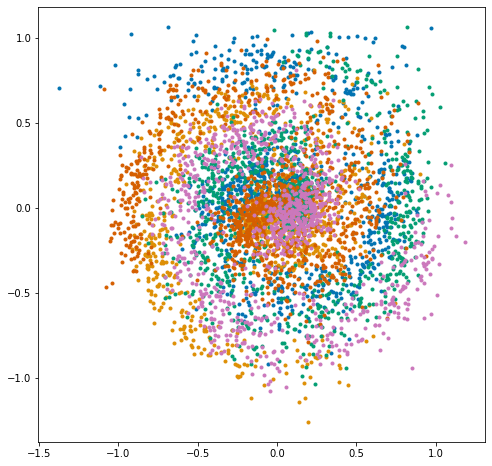

In [ ]:
def getNN(dense_size, input_size, levels = 2, n_labels = 2, **kwargs):
    network_base = keras.Sequential()
    network_base.add(layers.Dense(dense_size, activation='relu', input_shape=(input_size,)))
    for l in range(1, levels):
        network_base.add(layers.Dense(dense_size, activation='relu'))
    network_base.add(layers.Dense(units=n_labels, activation = 'softmax'))
    network_base.compile(**kwargs)
    return network_base

def get_posteriors(network, label):
    #define grids
    p = np.arange(-3, 3, step=0.01)
    q = np.arange(-3, 3, step=0.01)
    xx, yy = np.meshgrid(p, q)
    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    posteriors = network.predict_proba(grid_samples, label)
    posteriors = posteriors[:,0].reshape(600,600)

    return(posteriors)

# NN params
compile_kwargs = {
    "loss": "binary_crossentropy",
    "optimizer": keras.optimizers.Adam(3e-4),
}
fit_kwargs = {"epochs": 250, "batch_size": 32, "verbose": 0}

n_labels = 5
task_id = f"Spiral{n_labels}"
X1, y1 = generate_spirals(1000, n_class=n_labels)
X1_test, y1_test = generate_spirals(5000, n_class=n_labels)

nn_template = getNN(10, 2, 3, n_labels, **compile_kwargs)
kdn_spiral = kdn(network = nn_template, verbose=False)
kdn_spiral.fit(X1, y1, task_id, **fit_kwargs)
acc = np.mean(kdn_spiral.predict(X1_test, task_id) == y1_test)

Xgen, ygen = kdn_spiral.generate_data(5000, task_id)
print(f"{task_id} accuracy: {acc}")
plot_2dsim(Xgen, ygen)

### Posteriors

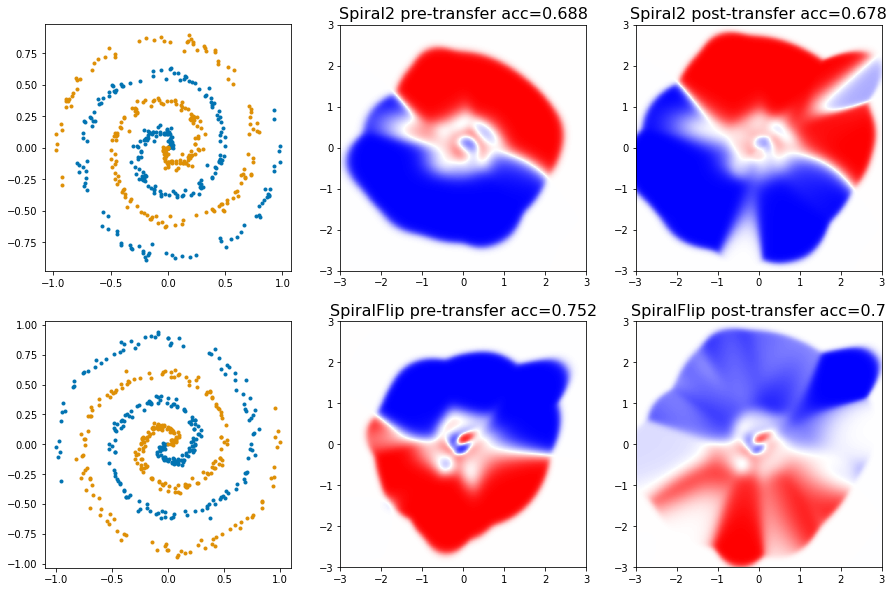

In [ ]:
n_train = 500
n_test = 1000

X1, y1 = generate_spirals(n_train, n_class=2)
X1_test, y1_test = generate_spirals(n_test, n_class=2)

X2, y2 = generate_spirals(n_train, n_class=2)
y2 = -1*(y2 - 1)
X2_test, y2_test = generate_spirals(n_test, n_class=2)
y2_test = -1*(y2_test - 1)

label1 = "Spiral2"
label2 = "SpiralFlip"

kdn_2task = kdn(network = nn_template, verbose=False)
kdn_2task.fit(X1, y1, label1, **fit_kwargs)
kdn_2task.fit(X2, y2, label2, **fit_kwargs)
post1 = get_posteriors(kdn_2task, label1)
post2 = get_posteriors(kdn_2task, label2)
t1_acc = np.mean(kdn_2task.predict(X1_test, label1) == y1_test)
t2_acc = np.mean(kdn_2task.predict(X2_test, label2) == y2_test)

fig1, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0,0] = plot_2dsim(X1, y1, ax=ax[0,0])
ax[1,0] = plot_2dsim(X2, y2, ax=ax[1,0])

ax[0, 1].imshow(
    post1,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 1].set_title(f"{label1} pre-transfer acc={t1_acc}", fontsize=16)
ax[0, 1].set_aspect("equal")

ax[1, 1].imshow(
    post2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 1].set_title(f"{label2} pre-transfer acc={t2_acc}", fontsize=16)
ax[1, 1].set_aspect("equal")

X1_trans, y1_trans = kdn_2task.generate_data(n_train, label1)
X2_trans, y2_trans = kdn_2task.generate_data(n_train, label2)
kdn_2task.forward_transfer(X1_trans, y1_trans, label1)
kdn_2task.forward_transfer(X2_trans, y2_trans, label2)

post1_trans = get_posteriors(kdn_2task, label1)
post2_trans = get_posteriors(kdn_2task, label2)
t1_acc_trans = np.mean(kdn_2task.predict(X1_test, label1) == y1_test)
t2_acc_trans = np.mean(kdn_2task.predict(X2_test, label2) == y2_test)

ax[0, 2].imshow(
    post1_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 2].set_title(f"{label1} post-transfer acc={t1_acc_trans}", fontsize=16)
ax[0, 2].set_aspect("equal")

ax[1, 2].imshow(
    post2_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 2].set_title(f"{label2} post-transfer acc={t2_acc_trans}", fontsize=16)
ax[1, 2].set_aspect("equal")

### Posteriors with bagging

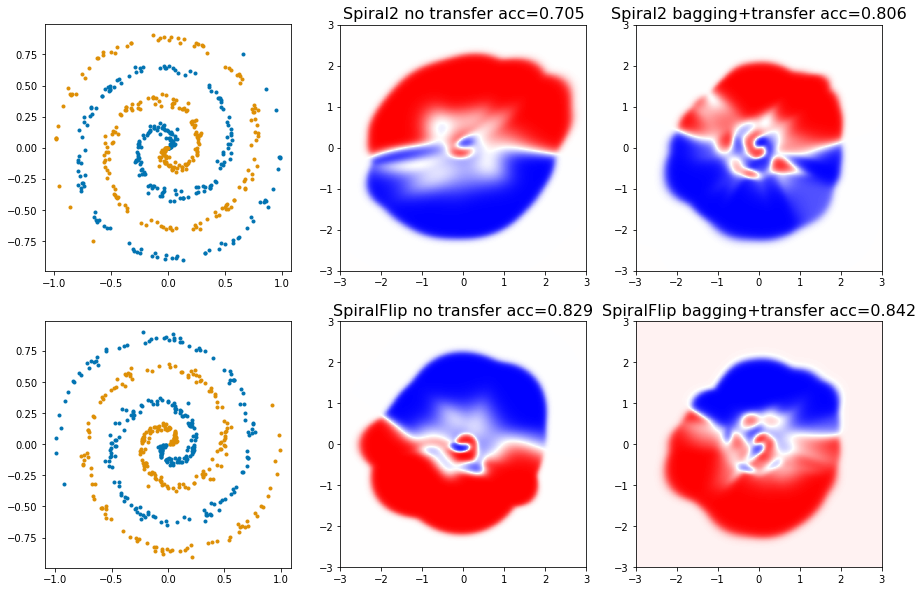

In [ ]:
n_train = 500
n_test = 1000

X1, y1 = generate_spirals(n_train, n_class=2)
X1_test, y1_test = generate_spirals(n_test, n_class=2)

X2, y2 = generate_spirals(n_train, n_class=2)
y2 = -1*(y2 - 1)
X2_test, y2_test = generate_spirals(n_test, n_class=2)
y2_test = -1*(y2_test - 1)

label1 = "Spiral2"
label2 = "SpiralFlip"

kdn_pretransfer = kdn(network = nn_template, verbose=False)
kdn_pretransfer.fit(X1, y1, label1, **fit_kwargs)
kdn_pretransfer.fit(X2, y2, label2, **fit_kwargs)
post1 = get_posteriors(kdn_pretransfer, label1)
post2 = get_posteriors(kdn_pretransfer, label2)
t1_acc = np.mean(kdn_pretransfer.predict(X1_test, label1) == y1_test)
t2_acc = np.mean(kdn_pretransfer.predict(X2_test, label2) == y2_test)

fig1, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0,0] = plot_2dsim(X1, y1, ax=ax[0,0])
ax[1,0] = plot_2dsim(X2, y2, ax=ax[1,0])

ax[0, 1].imshow(
    post1,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 1].set_title(f"{label1} no transfer acc={t1_acc}", fontsize=16)
ax[0, 1].set_aspect("equal")

ax[1, 1].imshow(
    post2,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 1].set_title(f"{label2} no transfer acc={t2_acc}", fontsize=16)
ax[1, 1].set_aspect("equal")

bag1 = np.random.randint(0, n_train, n_train)
bag2 = np.random.randint(0, n_train, n_train)
oob1 = np.setdiff1d(np.arange(0, n_train, 1), bag1)
oob2 = np.setdiff1d(np.arange(0, n_train, 1), bag2)

kdn_2task = kdn(network = nn_template, verbose=False)
kdn_2task.fit(X1[bag1], y1[bag1], label1, **fit_kwargs)
kdn_2task.fit(X2[bag2], y2[bag2], label2, **fit_kwargs)
X1_trans = X1[oob1]
y1_trans = y1[oob1]
X2_trans = X2[oob2]
y2_trans = y2[oob2]

kdn_2task.forward_transfer(X1_trans, y1_trans, label1)
kdn_2task.forward_transfer(X2_trans, y2_trans, label2)

post1_trans = get_posteriors(kdn_2task, label1)
post2_trans = get_posteriors(kdn_2task, label2)
t1_acc_trans = np.mean(kdn_2task.predict(X1_test, label1) == y1_test)
t2_acc_trans = np.mean(kdn_2task.predict(X2_test, label2) == y2_test)

ax[0, 2].imshow(
    post1_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0, 2].set_title(f"{label1} bagging+transfer acc={t1_acc_trans}", fontsize=16)
ax[0, 2].set_aspect("equal")

ax[1, 2].imshow(
    post2_trans,
    extent=[-3, 3, -3, 3],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1, 2].set_title(f"{label2} bagging+transfer acc={t2_acc_trans}", fontsize=16)
ax[1, 2].set_aspect("equal")

## Proglearn Figures

In [ ]:
#Modified Proglearn functions for running KDN_FT Spirals
def run_spiralexp(mc_rep, n_test, n_nodes, n_t1, n_t2, n_spirals_t1 = 3, n_spirals_t2 = 5):
    mean_error = np.zeros((6, len(n_t1) + len(n_t2)))
    std_error = np.zeros((6, len(n_t1) + len(n_t2)))
    mean_te = np.zeros((4, len(n_t1) + len(n_t2)))
    std_te = np.zeros((4, len(n_t1) + len(n_t2)))

    task1_id = f"Spiral{n_spirals_t1}"
    task2_id = f"Spiral{n_spirals_t2}"

    for i, n1 in enumerate(n_t1):
        print(f'starting to compute {n1} {task1_id}')
        error = Parallel(n_jobs = 2)(delayed(spiral_experiment)(n1, 0, task1_id, task2_id, n_spirals_t1, n_spirals_t2) for _ in range(mc_rep))
        error = np.array(error)
        mean_error[:, i] = np.mean(error, axis=0)
        std_error[:, i] = np.std(error, ddof=1, axis=0)
        mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
        mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
        mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
        mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

        if n1 == n_t1[-1]:
            for j, n2 in enumerate(n_t2):
                print(f'starting to compute {n2} {task2_id}')
                error = Parallel(n_jobs = 2)(delayed(spiral_experiment)(n1, n2, task1_id, task2_id, n_spirals_t1, n_spirals_t2) for _ in range(mc_rep))
                error = np.array(error)

                mean_error[:, i + j + 1] = np.mean(error, axis=0)
                std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
                mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
                mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
                mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
                mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    return mean_error, std_error, mean_te, std_te


def spiral_experiment(
    n_task1,
    n_task2,
    task1_id,
    task2_id,
    n_spirals_t1,
    n_spirals_t2,
    dense_layer_nodes = 10,
    dense_layers = 3,
    bagging = True,
    random_state=None,
):

    """
    A function to do KDN-FT experiment between a 3-spiral and a 5-spiral
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    n_task2 : int
        Total number of train dsample for task 2
    n_test : int, optional (default=1000)
        Number of test sample for each task.
    task1_id : str
        Name of Task 1
    task2_id : str
        Name of Task 2
    n_spirals_t1 : int, optional (default=3)
        # classes in task 1.
    n_spirals_t2 : int, optional (default=5)
        # classes in task 2.
    dense_layer_nodes : int, optional (default=10)
        Controls size of neural network
    dense_layers : int, optional (default=3)
        Controls # of layers in neural network (minimum 1)
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive KDN error task1,
        naive KDN task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    # source data
    X_task1, y_task1 = generate_spirals(n_task1, n_class = n_spirals_t1)
    test_task1, test_label_task1 = generate_spirals(n_task1, n_class = n_spirals_t1)

    # target data
    X_task2, y_task2 = generate_spirals(n_task2, n_class = n_spirals_t2)
    test_task2, test_label_task2 = generate_spirals(n_task2, n_class = n_spirals_t2)

    #Create KDNs
    nn_template = getNN(dense_layer_nodes, 2, dense_layers, **compile_kwargs)

    kdn_task1 = kdn(network = nn_template, verbose=False)
    kdn_task1.fit(X_task1, y_task1, task_id=task1_id, **fit_kwargs)

    if n_task2 == 0:
        single_task1 = kdn_task1.predict(test_task1, task_id=task1_id)
        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(single_task1 == test_label_task1)
        errors[2] = 0.5
        errors[3] = 0.5
        errors[4] = 1 - np.mean(single_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        kdn_task2 = kdn(network = nn_template, verbose=False)
        kdn_task2.fit(X_task2, y_task2, task_id=task2_id, **fit_kwargs)

        naive_X = np.concatenate((X_task1, X_task2), axis=0)
        naive_y = np.concatenate((y_task1, y_task2), axis=0)
        kdn_naive = kdn(network = nn_template, verbose=False)
        kdn_naive.fit(naive_X, naive_y, task_id="Naive", **fit_kwargs)

        kdn_prog = kdn(network = nn_template)

        #bagging code
        kdn_prog.fit(X_task1, y_task1, task_id=task1_id, **fit_kwargs)

        X_trans1, y_trans1 = kdn_prog.generate_data(n_task1, task1_id, force_equal_priors = False)
        if bagging:
            bag = np.random.randint(0, n_task2, n_task2)
            oob = np.setdiff1d(np.arange(0, n_task2, 1), bag)
            kdn_prog.fit(X_task2[bag], y_task2[bag], task_id=task2_id, **fit_kwargs)
            X_trans2 = X_task2[oob]
            y_trans2 = y_task2[oob]
        else:
            kdn_prog.fit(X_task2, y_task2, task_id=task2_id, **fit_kwargs)
            X_trans2, y_trans2 = kdn_prog.generate_data(n_task2, task2_id, force_equal_priors = False)

        kdn_prog.forward_transfer(X_trans1, y_trans1, task_id=task1_id)
        kdn_prog.forward_transfer(X_trans2, y_trans2, task_id=task2_id)

        single_task1 = kdn_task1.predict(test_task1, task_id=task1_id)
        single_task2 = kdn_task2.predict(test_task2, task_id=task2_id)
        naive_task1 = kdn_naive.predict(test_task1, task_id="Naive")
        naive_task2 = kdn_naive.predict(test_task2, task_id="Naive")
        prog_task1 = kdn_prog.predict(test_task1, task_id=task1_id)
        prog_task2 = kdn_prog.predict(test_task2, task_id=task2_id)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(prog_task1 == test_label_task1)
        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - np.mean(prog_task2 == test_label_task2)
        errors[4] = 1 - np.mean(naive_task1 == test_label_task1)
        errors[5] = 1 - np.mean(naive_task2 == test_label_task2)

    return errors

def plot_error_and_eff(n1s, n2s,
                       mean_error, mean_te,
                       TASK1, TASK2,
                       task1_data, task1_labels,
                       task2_data, task2_labels):
    """
    A function that plots the generalization error and
    transfer efficiency for any experiment
    Parameters
    ----------
    n1s : range(int)
        Array of sample sizes tested for the first learner.
    n2s : range(int)
        Array of sample sizes tested for the second learner.
    mean_error : np.array
        Array of generalization errors.
    mean_te : np.array
        Array of transfer efficiencies.
    task1 : str
        String of the name of the first task.
    task2 : str
        String of the name of the second task.
    task1_data : np.array
        Example data for training task 1
    task1_labels : np.array
        Labels associated with task1_data
    task2_data : np.array
        Example data for training task 2
    task2_labels : np.array
        Labels associated with task2_data
    """

    ns = np.concatenate((n1s, n2s + n1s[-1]))
    ls = ["-", "--"]

    ################################
    # Plots of Generalization Error
    ################################
    algorithms = [f"Single Task {TASK1}",
                  f"Transfer {TASK1}",
                  f"Single Task {TASK2}",
                  f"Transfer {TASK2}",
                  f"Naive {TASK1}",
                  f"Naive {TASK2}"]

    fontsize = 30
    labelsize = 28

    colors = sns.color_palette("Set1", n_colors=2)

    fig = plt.figure(constrained_layout=True, figsize=(21, 14))
    gs = fig.add_gridspec(14, 21)
    ax1 = fig.add_subplot(gs[7:, :6])
    ax1.plot(
        ns,
        mean_error[1],
        label=algorithms[1],
        c=colors[0],
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )
    ax1.plot(
        ns,
        mean_error[0],
        label=algorithms[0],
        c="g",
        ls=ls[np.sum(1 > 1).astype(int)],
        lw=3,
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK1), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.3, 0.5])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    ax1.set_title(f"{TASK1}", fontsize=30)

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ##############

    ax1 = fig.add_subplot(gs[7:, 7:13])

    ax1.plot(
        ns[len(n1s) :],
        mean_error[3, len(n1s) :],
        label=algorithms[3],
        c=colors[0],
        lw=3,
    )
    ax1.plot(
        ns[len(n1s) :], mean_error[2, len(n1s) :], label=algorithms[2], c="g", lw=3
    )

    ax1.set_ylabel("Generalization Error (%s)" % (TASK2), fontsize=fontsize)
    ax1.legend(loc="upper left", fontsize=20, frameon=False)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_yscale("log")
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.set_yticks([0.1, 0.3, 0.5])
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")

    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    ax1.set_title(f"{TASK2}", fontsize=30)

    ################################
    # Plots of Transfer Efficiency
    ################################

    algorithms = ["KDN BTE", "KDN FTE", "Naive BTE", "Naive FTE"]

    ax1 = fig.add_subplot(gs[7:, 14:])

    ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[1, len(n1s) :],
        label=algorithms[1],
        c=colors[0],
        ls=ls[1],
        lw=3,
    )
    ax1.plot(ns, mean_te[2], label=algorithms[2], c="g", ls=ls[0], lw=3)
    ax1.plot(
        ns[len(n1s) :],
        mean_te[3, len(n1s) :],
        label=algorithms[3],
        c="g",
        ls=ls[1],
        lw=3,
    )

    ax1.set_ylabel(
        "log Forward/Backward \n Transfer Efficiency (FTE/BTE)", fontsize=fontsize
    )
    ax1.legend(loc="lower left", fontsize=20, frameon=False)
    ax1.set_yticks([0.2, 0.6, 1, 1.2])
    ax1.set_ylim(0.2, 1.2)
    ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
    log_lbl = np.round(np.log([0.2, 0.6, 1, 1.2]), 2)
    labels = [item.get_text() for item in ax1.get_yticklabels()]

    for ii, _ in enumerate(labels):
        labels[ii] = str(log_lbl[ii])

    ax1.set_yticklabels(labels)
    ax1.tick_params(labelsize=labelsize)
    ax1.set_xticks([n1s[0], n1s[-1], ns[-1]])
    ax1.axvline(x=n1s[-1], c="blue", linewidth=1.5, linestyle="dashed")
    right_side = ax1.spines["right"]
    right_side.set_visible(False)
    top_side = ax1.spines["top"]
    top_side.set_visible(False)
    ax1.hlines(1, 50, 200, colors="gray", linestyles="dashed", linewidth=1.5)

    ax1.text(int(0.5*n1s[-1]), np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
    ax1.text(int(1.5*n1s[-2]), np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

    n_colors = max(len(np.unique(task1_labels)), len(np.unique(task2_labels)))
    colors = sns.color_palette("Dark2", n_colors=n_colors)

    ax = fig.add_subplot(gs[:6, 4:10])
    clr = [colors[i] for i in task1_labels]
    ax.scatter(task1_data[:, 0], task1_data[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(TASK1, fontsize=30)

    ax.axis("off")

    colors = sns.color_palette("Dark2", n_colors=2)

    ax = fig.add_subplot(gs[:6, 11:16])
    clr = [colors[i] for i in task2_labels]
    ax.scatter(task2_data[:, 0], task2_data[:, 1], c=clr, s=50)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(TASK2, fontsize=30)
    ax.axis("off")

In [ ]:
# define hyperparameters:
mc_rep = 20
n_nodes = 10
n_test = 5000
n_t1 = np.arange(50, 751, step=50).astype(int)
n_t2 = np.arange(50, 751, step=50).astype(int)

# running the experiment:

# run the experiment
mean_error, std_error, mean_te, std_te = run_spiralexp(mc_rep,
                                                       n_test,
                                                       n_nodes,
                                                       n_t1,
                                                       n_t2,
                                                       n_spirals_t1 = 3,
                                                       n_spirals_t2 = 5)

np.savez(f'/content/gdrive/My Drive/kdn_spirals_3-5.npz',
         task1 = n_t1, task2 = n_t2, mean_error = mean_error, mean_te = mean_te)

starting to compute 50 Spiral3
starting to compute 100 Spiral3
starting to compute 150 Spiral3
starting to compute 200 Spiral3
starting to compute 250 Spiral3
starting to compute 300 Spiral3
starting to compute 350 Spiral3
starting to compute 400 Spiral3
starting to compute 450 Spiral3
starting to compute 500 Spiral3
starting to compute 550 Spiral3
starting to compute 600 Spiral3
starting to compute 650 Spiral3
starting to compute 700 Spiral3
starting to compute 750 Spiral3


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


starting to compute 50 Spiral5
starting to compute 100 Spiral5
starting to compute 150 Spiral5
starting to compute 200 Spiral5
starting to compute 250 Spiral5
starting to compute 300 Spiral5
starting to compute 350 Spiral5
starting to compute 400 Spiral5
starting to compute 450 Spiral5
starting to compute 500 Spiral5


In [ ]:
n_t1 = np.arange(50, 751, step=50).astype(int)
n_t2 = np.arange(50, 751, step=50).astype(int)
n_data = 750

s3, s3_labels = generate_spirals(n_data, n_class = 3)
s5, s5_labels = generate_spirals(n_data, n_class = 5)

plot_error_and_eff(n_t1, n_t2,
                   mean_error, mean_te,
                   "Spiral3", "Spiral5",
                   s3, s3_labels,
                   s5, s5_labels):